# Aprendizado Semissupervisionado

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import csv
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

### Simulação dos dados

In [10]:
np.random.seed(0)
n_clusters = 4
exemplosTreino = 5

#Dados rotulados
x,y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1,
                          n_classes=n_clusters, n_samples=1000)

rotuladoPos = []; naoRotuladoPos = []; geralPos = []
for i in range(n_clusters):
    posClass = np.where(y == i)
    posRand = posClass[0][ np.argsort( np.random.uniform(0,1,len(posClass[0]))).tolist() ]
    
    for item in posRand[0:exemplosTreino]: rotuladoPos.append(item)
    for item in posRand[exemplosTreino:]: naoRotuladoPos.append(item)

xD = x[rotuladoPos,:]
yD = y[rotuladoPos]
xI = x[naoRotuladoPos,:]
yI = y[naoRotuladoPos]

### Visualização do conjunto simulado

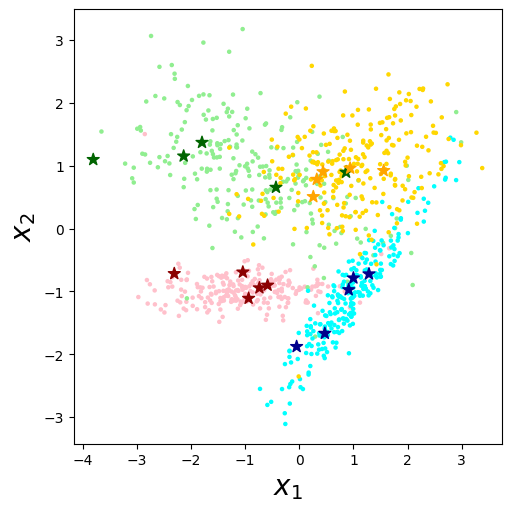

In [11]:
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
corI = ['pink','lightgreen','cyan','gold']; corD = ['darkred','darkgreen','darkblue','orange']
vecI = []; vecD = []
for i in yI: vecI.append(corI[i])
for i in yD: vecD.append(corD[i])

ax = fig.add_subplot(spec[0, 0])    
ax.scatter(xI[:,0],xI[:,1], marker='.', c=vecI, s=20) # type: ignore
ax.scatter(xD[:,0],xD[:,1], marker='*', c=vecD, s=80) # type: ignore
ax.set_xlabel('$x_1$',fontsize=20)
ax.set_ylabel('$x_2$',fontsize=20)
plt.show()

In [12]:
path_data_Rotulado = 'Data/simTreino.txt'
path_data_naoRotulado = 'Data/simNaoRotulado.txt'

#Conjunto rotulado
f= open(path_data_Rotulado,"w")
for i in range(len(yD)):
    st = str(yD[i])
    for j in range(0,xD.shape[1]):
        st += ','+ str(xD[i,j])
    st += '\n'
    f.write(st)
f.close()

#Conjunto não rotulado (de avaliação)
f= open(path_data_naoRotulado,"w")
for i in range(len(yI)):
    st = str(yI[i])
    for j in range(0,xI.shape[1]):
        st += ','+ str(xI[i,j])
    st += '\n'
    f.write(st)
f.close()

## Rotulação de agrupamentos

In [13]:
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack((data, np.asarray(row).astype(float))) # type: ignore
            except:
                data = np.asarray(row).astype(float)
    f.close()
    y = data[:,0] # type: ignore
    x = data[:,1:] # type: ignore
    return y,x

In [14]:
path_data_Rotulado = 'Data/simTreino.txt'
path_data_naoRotulado = 'Data/simNaoRotulado.txt'

yD,xD = read_class_data(path_data_Rotulado) #Dados de treinamento
yI,xI = read_class_data(path_data_naoRotulado) #Dados não rotulados (avaliação)

### Execução do método

In [39]:
n_clusters = 10
data = np.append(xD, xI, axis=0)
labels = np.append(yD, np.zeros(yI.shape[0])-1, axis=0)
t = data.shape[0] #quantidade de padrões envolvidos no problema
c = len(np.unique(yD)) #quantidade de classes...

g = KMeans(n_clusters=n_clusters, random_state=0)
agrup = g.fit_predict(data)

pred = np.zeros(t)-1 #Elementos identificados por -1 não possui rótulo associado
for i in range(0,n_clusters):
    posAgrup = np.where(agrup == i)[0]
    countClass = np.zeros(c)
    for item in posAgrup:
        if labels[item] != -1:
            countClass[int(labels[item])] += 1

    if np.sum(countClass) != 0:
        win = np.argmax(countClass)
        pred[posAgrup] = win

### Avaliação 

In [40]:
posAvalia = np.where(labels == -1)
accuracia = np.count_nonzero( pred[posAvalia] == yI )/yI.shape[0]
print('Acurácia: ',accuracia)

Acurácia:  0.8285714285714286


### Visualização dos resultados

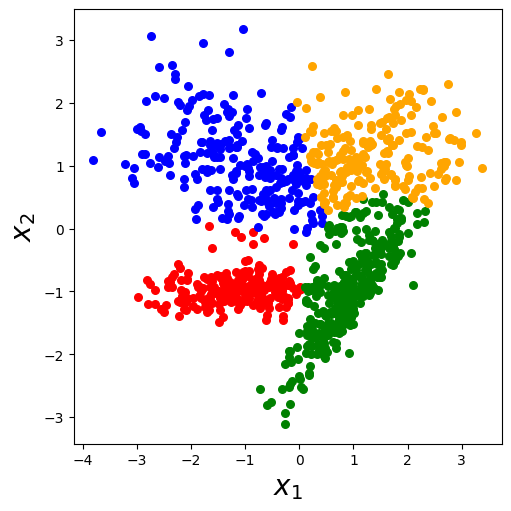

In [41]:
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
cores = ['red','blue','green','orange']
ax = fig.add_subplot(spec[0,0])

for i in range(0,c):
    pos = np.where( np.array(pred) == i)
    ax.scatter(data[pos, 0], data[pos, 1], marker='o', c=cores[i], s=30) # type: ignore
    
pos = np.where( np.array(pred) == -1)
if len(pos) > 0: ax.scatter(data[pos, 0], data[pos, 1], marker='o', c='black', s=30) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()

## Mistura de gaussianas

#### Distribuição gaussiana multivariada

In [44]:
def multivariate_gaussian(x, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    fator = 1 / np.sqrt((2*np.pi)**n * Sigma_det)
    expo = (((x-mu).T).dot(Sigma_inv)).dot(x-mu)
    return np.exp(-0.5*expo) / fator


#### Inicialização dos lambdas

In [45]:
def init_lambda(xD,mu,sigm):
    m,_ = xD.shape
    _,c = mu.shape
    lamb = np.zeros((c))
    for ind in range(c):
        for i in range(m):
            lamb[int(ind)] += multivariate_gaussian(xD[i,:], mu[:,int(ind)], sigm[:,:,int(ind)])

    lamb[:] /= np.sum(lamb)
    return lamb

#### Inicialização dos parametros

In [46]:
def init_pars_gmm(data,labels):
    _,n = data.shape
    c = len(np.unique(labels))
    mu = np.ndarray((n,c)) #vetores médio
    sigm = np.ndarray((n,n,c)) #matrizes de covariância

    for ind in np.unique(labels):
        pos = np.where(labels == ind)
        mu[:,int(ind)] = np.mean( data[pos,:].reshape((len(pos[0]),n)), axis=0)
        sigm[:,:,int(ind)] = np.cov(data[pos,:].reshape((len(pos[0]),n)), rowvar=False)
    return mu, sigm

### Inicialização dos parâmetros e treinamento do GMM

In [47]:
muInit, sigmaInit = init_pars_gmm(xD,yD)
lamb = init_lambda(xD,muInit,sigmaInit)

G = GaussianMixture(n_components=len(np.unique(yD)),
                    means_init=muInit.T,weights_init=lamb,
                    covariance_type='full',random_state=0)

G.fit(data)
predProb = G.predict_proba(data)
pred = np.argmax(G.predict_proba(data),axis=1)
predI = np.argmax(G.predict_proba(xI),axis=1)
predD = np.argmax(G.predict_proba(xD),axis=1)

#Cálculo da acurácia
acuracia = np.count_nonzero( np.where( np.array(predI) == yI ) )/yI.shape[0]
print('Acurácia: ',acuracia)

Acurácia:  0.8642857142857143


### Visualização

[]

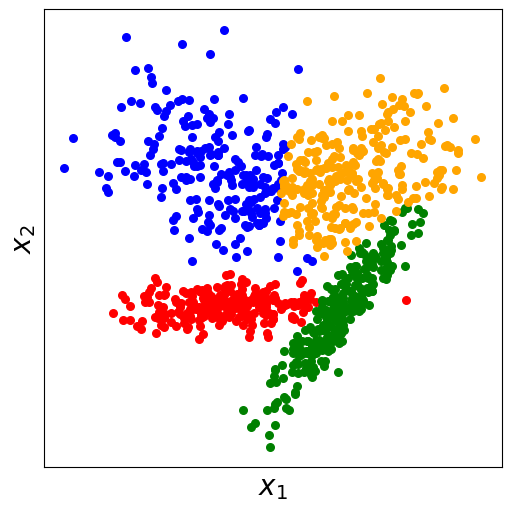

In [48]:
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
marr = ['o','s','^','D']
cores = ['red','blue','green','orange']
ax = fig.add_subplot(spec[0,0])

for i in range(0,len(np.unique(yD))):
    pos = (np.where( np.array(pred) == i))[0]
    ax.scatter(data[pos, 0], data[pos, 1], marker='o', c=cores[i], s=30) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

## Autotreinamento e cotreinamento 

#### Estrada dos parâmetros

In [51]:
def compute_pars_gauss_multi(x,y):
    _,n = x.shape
    c = len(np.unique(y))
    mu = np.ndarray((n,c))
    sigm = np.ndarray((n,n,c))

    for ind in np.unique(y):
        pos = np.where(y == ind)
        mu[:,int(ind)] = np.mean( x[pos,:].reshape((len(pos[0]),n)), axis=0)
        sigm[:,:,int(ind)] = np.cov(x[pos,:].reshape((len(pos[0]),n)), rowvar=False)
    return mu, sigm

#### Configurações usadas no processo
* Número máximo de autotreinamentos
* Nível de confiança exigido

In [52]:
repeticoes = 15
nivel = 0.8

#### Execução do método
* O método MLC é usado neste processo
* A "confiança" é medida por $\displaystyle \frac{p(x_i|\omega_j)}{max \{ p(x_k|\omega_j) \}}, k=1,\ldots,m$

In [53]:
yDcopy = np.copy(yD); xDcopy = np.copy(xD)
yIcopy = np.copy(yI); xIcopy = np.copy(xI)
iteracao = 0

while (iteracao < repeticoes) and (len(yI) > 0): # type: ignore
    m,n = xI.shape; c = len(np.unique(yD)) # type: ignore
    mu,sigm = compute_pars_gauss_multi(xD, yD) # type: ignore
    conf = np.ndarray((m,c))
    refConf = np.zeros((c))
    for i in range(m):
        for j in range(c):
            conf[i,j] = multivariate_gaussian(xI[i,:], mu[:,j], sigm[:,:,j]) # type: ignore
            if conf[i,j] > refConf[j]:
                refConf[j] = conf[i,j]

    for j in range(c):
        conf[:,j] /= refConf[j]

    itensRemove = []
    
    for i in range(m):
        pos1 = np.where(conf[i,:] > nivel)[0]
        if len(pos1) > 0:
            pos2 = np.argmax(conf[i,pos1])
            xD = np.append(xD, (xI[i,:]).reshape((1,n)), axis=0) # type: ignore
            yD = np.append(yD, pos1[pos2]) # type: ignore
            itensRemove.append(i)

    if len(itensRemove) > 0:
        xI = np.delete(xI, itensRemove, axis=0) # type: ignore
        yI = np.delete(yI, itensRemove) # type: ignore

    iteracao += 1

### Desempenho do método MLC *com* autotreinamento

In [54]:
mu,sigm = compute_pars_gauss_multi(xD, yD)
pred = np.zeros((yIcopy.shape[0]))
maxlike = np.ndarray((c)) #Vetor para armazenar os valor de verossimilhança
for i in range(yIcopy.shape[0]):
    for j in range(c):
        maxlike[j] = multivariate_gaussian(xIcopy[i,:], mu[:,j], sigm[:,:,j])
    pred[i] = np.argmax(maxlike)
    
acuracia = np.count_nonzero(pred == yIcopy)/yIcopy.shape[0]
print('Acurácia: ',acuracia)

Acurácia:  0.813265306122449


### Desempenho do método MLC *sem* autotreinamento

In [55]:
mu,sigm = compute_pars_gauss_multi(xDcopy,yDcopy)
predSem = np.zeros((yIcopy.shape[0]))
maxlike = np.ndarray((c)) #Vetor para armazenar os valor de verossimilhança
for i in range(yIcopy.shape[0]):
    for j in range(c):
        maxlike[j] = multivariate_gaussian(xIcopy[i,:], mu[:,j], sigm[:,:,j])
    predSem[i] = np.argmax(maxlike)

acuracia = np.count_nonzero(predSem == yIcopy)/yIcopy.shape[0]
print('Acurácia: ',acuracia)

Acurácia:  0.6989795918367347


### Visualização dos resultados

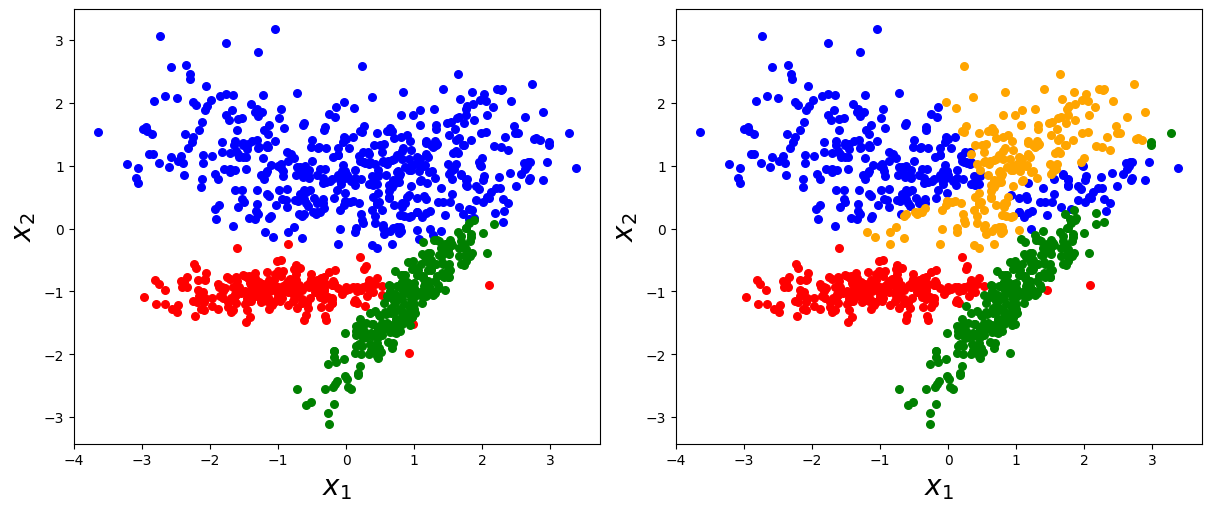

In [56]:
FS = (12,5)
fig = plt.figure(constrained_layout=True, figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
cores = ['red','blue','green','orange']
# sem autotreinamento
ax = fig.add_subplot(spec[0,0])

for i in range(0,c):
    pos = np.where( np.array(predSem) == i)[0]
    ax.scatter(xIcopy[pos, 0], xIcopy[pos, 1], marker='o', c=cores[i], s=30) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
# com autotreinamento
ax = fig.add_subplot(spec[0,1])

for i in range(0,c):
    pos = np.where( np.array(pred) == i)[0]
    ax.scatter(xIcopy[pos, 0], xIcopy[pos, 1], marker='o', c=cores[i], s=30) # type: ignore

ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()

## Modelagem baseado em grafo

In [57]:
def graph_ssl(data,label): #yD,sig,alpha
    t = data.shape[0]
    c = len(np.unique(yD))
    Y = np.zeros((t,c))

    for i in range(t):
        if labels[i] != -1:
            Y[i,int(labels[i])] = 1

    H = np.zeros((t,t))
    for i in range(t-1):
        for j in range(i+1,t):
            H[i,j] = np.exp(-(np.linalg.norm(data[i,:]-data[j,:])**2)/(2*(sig**2)))
            H[j,i] = H[i,j]

    Q = np.zeros((t,t))
    for i in range(t):
        Q[i,i] = 1/np.sum(H[i,:])

    S = (Q.dot(H)).dot(Q)
    U = np.linalg.inv( np.identity(t) - alpha*S)
    U = U.dot(Y)
    
    return U

### Configurações usadas no processo
* sig -- $\sigma$ -- controla a expressão das medidas de afinidade
* alpha -- $\alpha$ -- controla a expressão de pertinência padrões-classe

In [58]:
sig = 2.0
alpha = 1.5

In [59]:
data = np.append(xD,xI, axis=0)
labels = np.append(yD, np.zeros(yI.shape[0])-1 ,axis=0)

U = graph_ssl(data,labels)

t,c = U.shape
pred = np.zeros((t))
for i in range(t):
    pred[i] = np.argmax( U[i,:] )

### Avaliação

In [60]:
posAvalia = np.where(labels == -1)[0]
acuracia = np.count_nonzero( pred[posAvalia] == yI )/yI.shape[0]
print(acuracia)

0.7470414201183432


### Visualização dos resultados

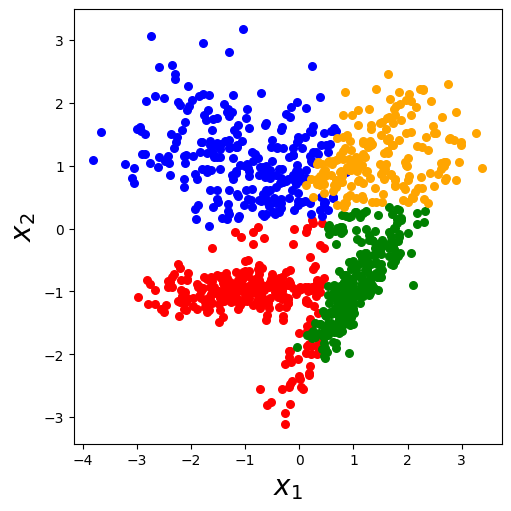

In [61]:
FS = (5,5)
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
cores = ['red','blue','green','orange']
ax = fig.add_subplot(spec[0,0])

for i in range(c):
    pos = np.where( np.array(pred) == i)
    ax.scatter(data[pos, 0], data[pos, 1], marker='o', c=cores[i], s=30)
    
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
plt.show()